In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [47]:
data=pd.read_csv('predictive_maintenance.csv')

In [48]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [49]:
data.info

<bound method DataFrame.info of         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  

In [50]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [51]:
#Here we will remove both UDI and ProductID as they are not much useful for this preprocessing step
data=data.drop(['UDI','Product ID'], axis=1)  # removes entire column when axis=1
data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [52]:
data.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

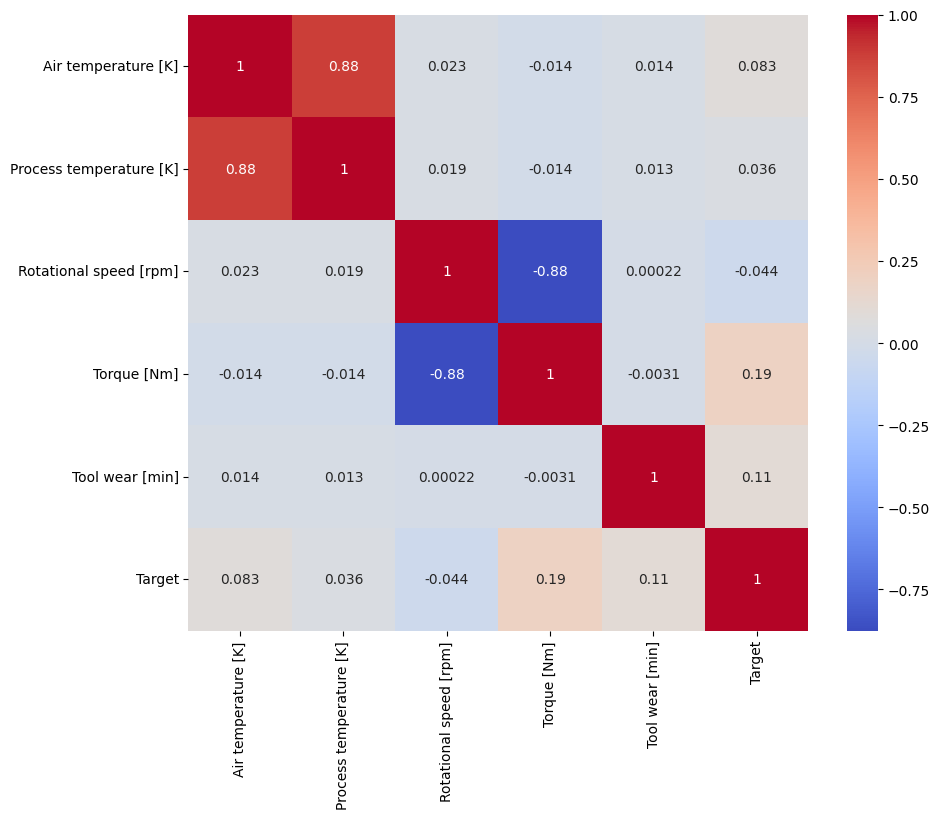

In [53]:
#no null values found
#now we will try to find out highly correlated attributes with the target variable
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix=numeric_data.corr()

#plot the heat map
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.show()

In [54]:
#creating new features
data['Torque_per_RPM'] = data['Torque [Nm]'] / data['Rotational speed [rpm]']
data['Temp_Diff'] = data['Process temperature [K]'] - data['Air temperature [K]']
data.head(1)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Torque_per_RPM,Temp_Diff
0,M,298.1,308.6,1551,42.8,0,0,No Failure,0.027595,10.5


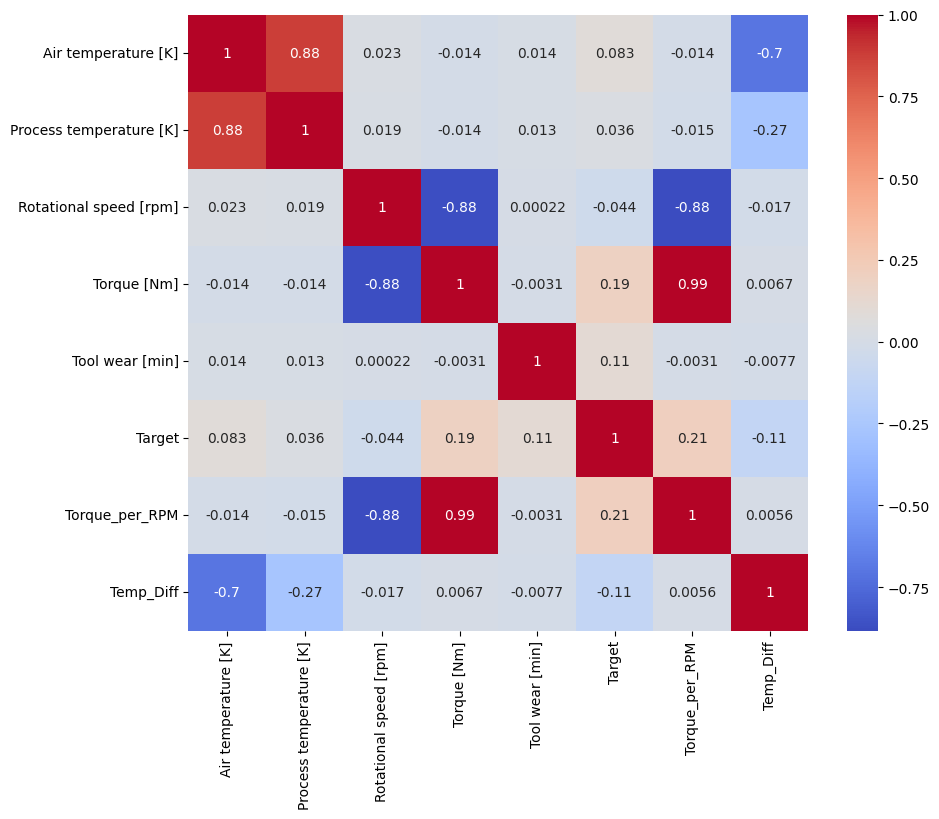

In [55]:
#we don't have many highly correlated variables so we must create some new features
#now we will try to find out highly correlated attributes with the newly included features as well
#new features are Torque_per_RPM nad Temp_Diff
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix=numeric_data.corr()

#plot the heat map
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.show()

1. The two highly correlated variables are process temperature and torque per RPM
2. We'll create another feature that captures the combined effect of 2 highly correlated variables, they are process temperature and torque_per_RPM

In [56]:
data['Temp_Torque_Interaction'] = data['Process temperature [K]'] * data['Torque_per_RPM']
data.head(1)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Torque_per_RPM,Temp_Diff,Temp_Torque_Interaction
0,M,298.1,308.6,1551,42.8,0,0,No Failure,0.027595,10.5,8.515848


1. Now we will generate some polynomial features
2. Polynomial features are used to model non-linear relationships between the features and the target variable. If the relationship between a feature and the target is not linear, adding polynomial features can help the model capture that complexity.
3. If you have a feature x and a target variable y where the relationship is quadratic (y = ax^2 + bx + c), using only the linear feature x might not capture the true relationship well. However, if you generate a polynomial feature like x^2, the model can better capture the quadratic relationship.
4. Polynomial features can improve the model's performance by allowing it to fit more complex patterns in the data. However, they can also increase the risk of overfitting if not used carefully, especially if you generate high-degree polynomials.

In [57]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(data[['Process temperature [K]', 'Torque_per_RPM']])
data.head(1)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Torque_per_RPM,Temp_Diff,Temp_Torque_Interaction
0,M,298.1,308.6,1551,42.8,0,0,No Failure,0.027595,10.5,8.515848


In [62]:
#1. Combine Polynomial Features with Original Data
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
data = pd.concat([data, poly_df], axis=1)
data.head(3)

,Type,Process temperature [K],Rotational speed [rpm],Torque [Nm],Target,Failure Type,Torque_per_RPM,Temp_Diff,Temp_Torque_Interaction,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2
0,M,308.6,1551,42.8,0,No Failure,0.027595,10.5,8.515848,308.6,0.027595,95233.96,8.515848,0.000761,308.6,0.027595,95233.96,8.515848,0.000761
1,L,308.7,1408,46.3,0,No Failure,0.032884,10.5,10.151143,308.7,0.032884,95295.69,10.151143,0.001081,308.7,0.032884,95295.69,10.151143,0.001081
2,L,308.5,1498,49.4,0,No Failure,0.032977,10.4,10.173498,308.5,0.032977,95172.25,10.173498,0.001088,308.5,0.032977,95172.25,10.173498,0.001088


In [65]:
#we don't need some features so we are dropping them
data=data.drop(['Type'],axis=1)
data.head(1)

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Target,Failure Type,Torque_per_RPM,Temp_Diff,Temp_Torque_Interaction,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2
0,308.6,1551,42.8,0,No Failure,0.027595,10.5,8.515848,308.6,0.027595,95233.96,8.515848,0.000761,308.6,0.027595,95233.96,8.515848,0.000761


In [69]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Failure Type'] = encoder.fit_transform(data['Failure Type'])
data.head(1)

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Target,Failure Type,Torque_per_RPM,Temp_Diff,Temp_Torque_Interaction,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2,Process temperature [K],Torque_per_RPM,Process temperature [K]^2,Process temperature [K] Torque_per_RPM,Torque_per_RPM^2
0,308.6,1551,42.8,0,1,0.027595,10.5,8.515848,308.6,0.027595,95233.96,8.515848,0.000761,308.6,0.027595,95233.96,8.515848,0.000761


In [68]:
#Apply feature scaling to improve the model performance
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [70]:
#split the data into training and testing data
X = data.drop(columns=['Target'])
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
#train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
#evaluate the model
y_pred = model.predict(X_test)

In [73]:
#evaluate the model performance using pre defined metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9985
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       0.98      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [74]:
#check feature importance between the actual features and polynomial features
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                                   Feature  Importance
3                             Failure Type    0.595366
5                                Temp_Diff    0.068858
2                              Torque [Nm]    0.060731
1                   Rotational speed [rpm]    0.038887
11                        Torque_per_RPM^2    0.033152
13                          Torque_per_RPM    0.030843
16                        Torque_per_RPM^2    0.025551
15  Process temperature [K] Torque_per_RPM    0.025147
6                  Temp_Torque_Interaction    0.022916
10  Process temperature [K] Torque_per_RPM    0.022299
8                           Torque_per_RPM    0.021844
4                           Torque_per_RPM    0.019718
7                  Process temperature [K]    0.008258
0                  Process temperature [K]    0.007842
9                Process temperature [K]^2    0.006281
12                 Process temperature [K]    0.006248
14               Process temperature [K]^2    0.006057


In [75]:
#perform cross validation and make sure model does not overfit
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.999  0.9975 0.983  0.994  0.999 ]
Mean cross-validation score: 0.9945


In [76]:
#perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier instance
model = RandomForestClassifier()

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.998


In [77]:
# Predict on test data
y_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9985
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       0.98      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000

